In [198]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

In [199]:
# matlotib settings
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Computer Modern Roman'
plt.rcParams['font.size'] = 15
plt.rcParams['xtick.minor.size'] = 5

Measuring GM Tube Plateau Curve to find operating voltage

In [200]:
# Importing the dataset
data_plateau = np.loadtxt('../data/RadiationLabPlateau.tsv', delimiter='\t', usecols=(0,1, 2), skiprows=11).T

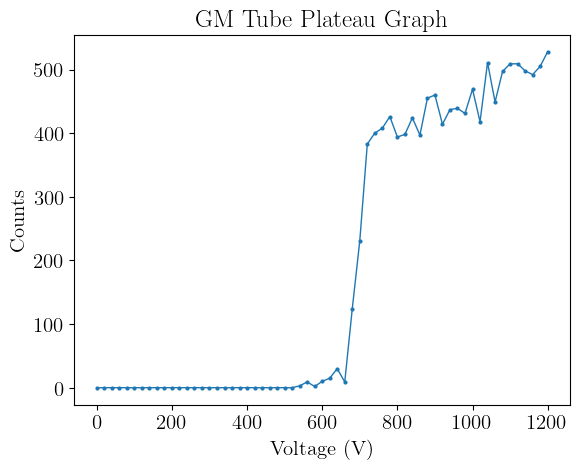

In [201]:
plt.plot(data_plateau[1], data_plateau[2], "o-", lw=1, ms=2, label="data")
plt.xlabel("Voltage (V)")
plt.ylabel("Counts")
plt.title("GM Tube Plateau Graph")
plt.savefig("../plots/PlateauGraph.png", dpi = 300)

We decided to use 900 V as the operating voltage for the GM tube since it in the middle of the plateau curve before the tube starts to saturate.

Measuring the background of the GM tube

In [202]:
data_background = np.loadtxt('../data/BackgroundCountData.tsv', delimiter='\t', skiprows=11, usecols=(0,1, 2)).T

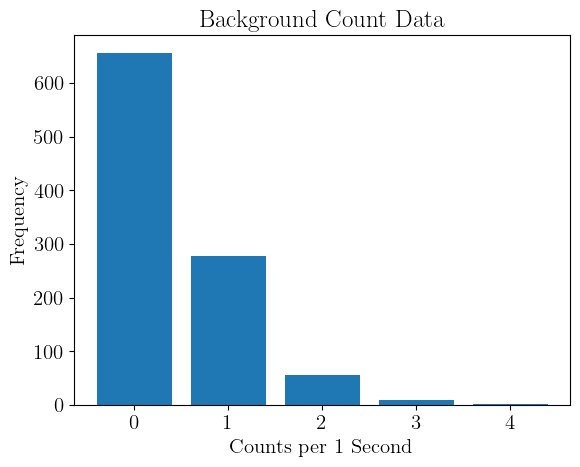

In [203]:
labels, counts = np.unique(data_background[2], return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.xlabel("Counts per 1 Second")
plt.ylabel("Frequency")
plt.title("Background Count Data")
plt.savefig("../plots/BackgroundCountHist1sec.png", dpi=300)

In [204]:
data_background_10 = np.array([np.sum(data_background[2][10*i:10*(i+1)]) for i in range(100)])

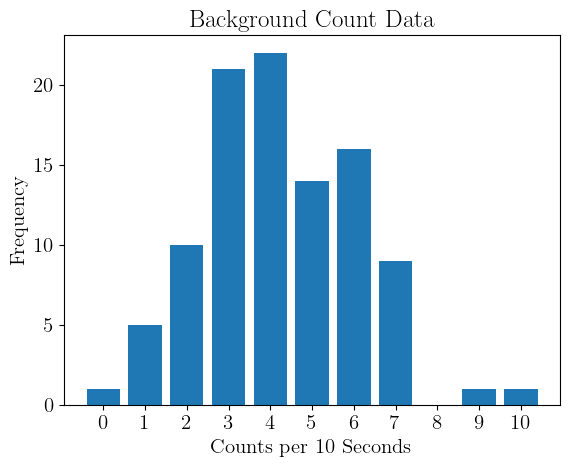

In [205]:
labels, counts = np.unique(data_background_10, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(range(11))
plt.xlabel("Counts per 10 Seconds")
plt.ylabel("Frequency")
plt.title("Background Count Data")
plt.savefig("../plots/BackgroundCountHist10sec.png", dpi = 300)

In [206]:
data_background_100 = np.array([np.sum(data_background[2][100*i:100*(i+1)]) for i in range(10)])
data_background_100

array([48., 44., 37., 32., 51., 37., 39., 42., 48., 46.])

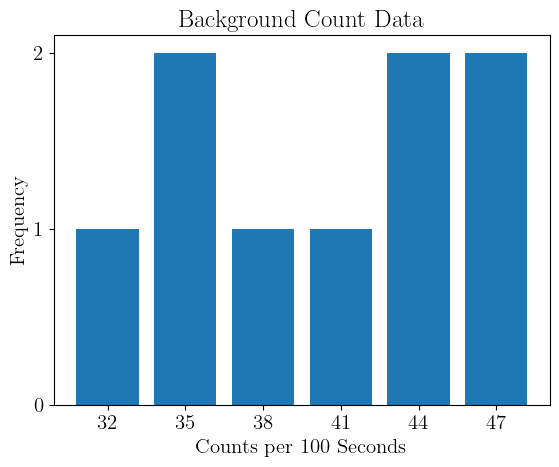

In [207]:
plt.hist(data_background_100, bins = range(32, 53, 3), align="left", rwidth=0.8)
plt.xlabel("Counts per 100 Seconds")
plt.xticks(range(32, 50, 3))
plt.yticks(range(0, 3))
plt.ylabel("Frequency")
plt.title("Background Count Data")
plt.savefig("../plots/BackgroundCountHist100sec.png", dpi = 300)

In [208]:
mean_background_rate = np.mean(data_background[2])
std_background_rate = np.std(data_background[2])
mean_std_background_rate = std_background_rate/np.sqrt(len(data_background[2]))
print(f"Reported Background Count Rate: {mean_background_rate} +/- {mean_std_background_rate} counts per second")

Reported Background Count Rate: 0.424 +/- 0.020838042134519265 counts per second


Measuring the count rate of Cs137

In [209]:
data_cs137 = np.loadtxt('../data/Cs137CountData.tsv', delimiter='\t', skiprows=11, usecols=(0,1, 2)).T

In [210]:
mean_cs137_rate = np.mean(data_cs137[2])
std_cs137_rate = np.std(data_cs137[2])
mean_std_cs137_rate = std_cs137_rate/np.sqrt(len(data_cs137[2]))
print(f"Reported Cs137 Count Rate: {mean_cs137_rate} +/- {mean_std_cs137_rate} counts per second")

Reported Cs137 Count Rate: 1.014 +/- 0.03224599199900664 counts per second


Measuring the count rate of Co60

In [211]:
data_co60 = np.loadtxt('../data/Co60CountData.tsv', delimiter='\t', skiprows=11, usecols=(0,1, 2)).T

In [212]:
mean_co60_rate = np.mean(data_co60[2])
std_co60_rate = np.std(data_co60[2])
mean_std_co60_rate = std_co60_rate/np.sqrt(len(data_co60[2]))
print(f"Reported Co60 Count Rate: {mean_co60_rate} +/- {mean_std_co60_rate} counts per second")

Reported Co60 Count Rate: 9.596 +/- 0.09744118225883756 counts per second
